# Exploration of NCD topology

Queries to obtain the CSV files:

`graphs.csv`:
`SELECT lbltype, compid, ncd_formula, dist_aggregator, seqpart, seqid_1, seqid_2, seqid_train, lbl, dist FROM PairwiseDistances JOIN Labels JOIN Sequences WHERE Labels.seqid = seqid_train AND Sequences.seqid = seqid_1`

`traingraph.csv` :
`SELECT lbltype, compid, ncd_formula, seqid_other, seqid_train, LblTrain.lbl, ncd_value from TrainingPairings JOIN Sequences ON Sequences.seqid = seqid_other JOIN Labels AS LblTrain ON LblTrain.seqid = seqid_train WHERE seqpart > 0`

`labels.csv`:
`SELECT lbltype, seqid, lbl FROM Labels`

`seqs.csv` :
`SELECT seqid, seqpart, GROUP_CONCAT(tokval, ' ') AS seq FROM Sequences NATURAL JOIN SequenceValues NATURAL JOIN Alphabet GROUP BY seqid`

In [1]:
import math
import sqlite3 as sql
import dask.dataframe as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [32]:
FOLDER = 'E:/diss/reuters/'
GRAPHS = 'C:/Users/Mr Barrett/Dropbox/Diss/graphs/'

In [24]:
LBLTYPE = 86  # wheat
COMPNAME = 0
NCD_FORMULA = "norm-inf-dist-1"

In [4]:
df = pd.read_csv(FOLDER + "graphs.csv")
df = df[(df["compid"] == COMPNAME) & (df["ncd_formula"] == NCD_FORMULA) & (df["seqpart"] == 1)].compute()

In [5]:
df["weight"] = 1.0 / df["dist"]
df

,compid,ncd_formula,dist_aggregator,seqpart,seqid_1,seqid_2,seqid_train,dist,weight
1143566,0,norm-inf-dist-1,mp,1,0,2,3976,1.804914,0.554043
1143567,0,norm-inf-dist-1,mp,1,2,0,3976,1.804914,0.554043
1143568,0,norm-inf-dist-1,mp,1,0,4,3325,1.799317,0.555766
1143569,0,norm-inf-dist-1,mp,1,4,0,3325,1.799317,0.555766
1143570,0,norm-inf-dist-1,mp,1,0,6,3459,1.831853,0.545895
...,...,...,...,...,...,...,...,...,...
834713,0,norm-inf-dist-1,mp,1,3016,3014,7051,1.682795,0.594249
834714,0,norm-inf-dist-1,mp,1,3014,3018,3063,1.658857,0.602825
834715,0,norm-inf-dist-1,mp,1,3018,3014,3063,1.658857,0.602825
834718,0,norm-inf-dist-1,mp,1,3016,3018,7051,1.512498,0.661158


In [6]:
df["seqid_train"].nunique()

358

In [7]:
lbls = pd.read_csv(FOLDER + "labels.csv").compute()
lbls = { (row["lbltype"], row["seqid"]) : row["lbl"] for index, row in lbls.iterrows() }

In [8]:
seqs = pd.read_csv(FOLDER + "seqs.csv").set_index("seqid")
seqs.head(5)

,seqpart,seq
seqid,,
0,1,[CLS] asian export ##ers fear damage from u . ...
1,2,[CLS] china daily says ve ##rmin eat 7 - 12 pc...
2,1,[CLS] japan to rev ##ise long - term energy de...
3,2,[CLS] thai trade deficit widen ##s in first qu...
4,1,[CLS] indonesia sees cp ##o price rising sharp...


In [9]:
G = nx.from_pandas_edgelist(df, "seqid_1", "seqid_2", ["weight", "dist", "seqid_train"])
G_mst = nx.minimum_spanning_tree(G, weight="dist")

In [25]:
lbl_counts = [0, 0]
for seqid in G.nodes():
    lbl_counts[lbls[(LBLTYPE, seqid)]] += 1

print("Baseline accuracy:", max(lbl_counts) / sum(lbl_counts))

Baseline accuracy: 0.9781456953642385


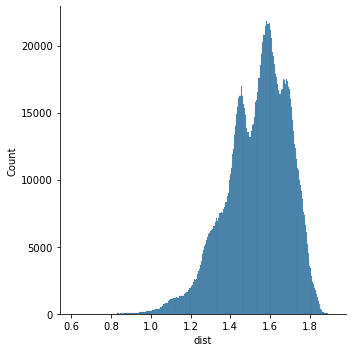

In [11]:
sns.displot(df["dist"])

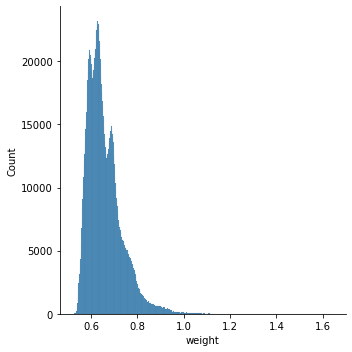

In [12]:
sns.displot(df["weight"])

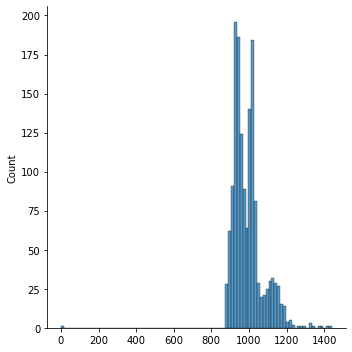

In [13]:
sns.displot(nx.laplacian_spectrum(G))

In [26]:
node_colours = [('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G.nodes()]
edge_opacities = list(nx.get_edge_attributes(G, "weight").values())
edge_opacities = [0.0 if a < 1.0 else 0.2 * (a - 1.0) / 3.0 for a in edge_opacities]

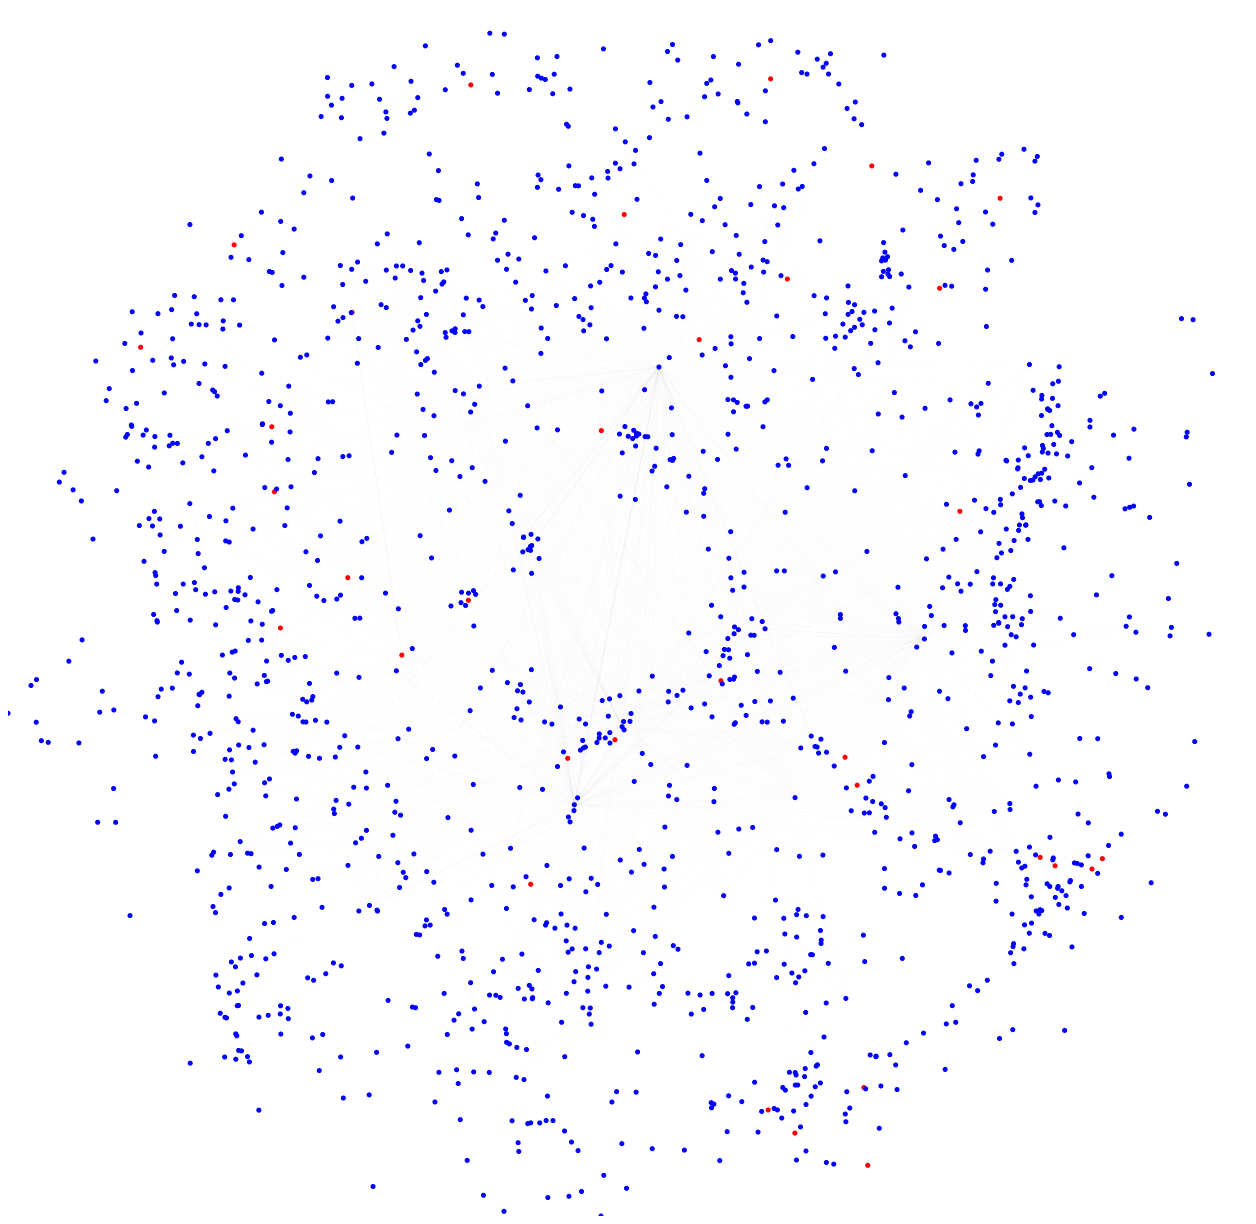

In [27]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G, weight="weight")
nx.draw_networkx_nodes(G, pos, node_shape='.', node_size=50, node_color=node_colours)
nx.draw_networkx_edges(G, pos, alpha=edge_opacities)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

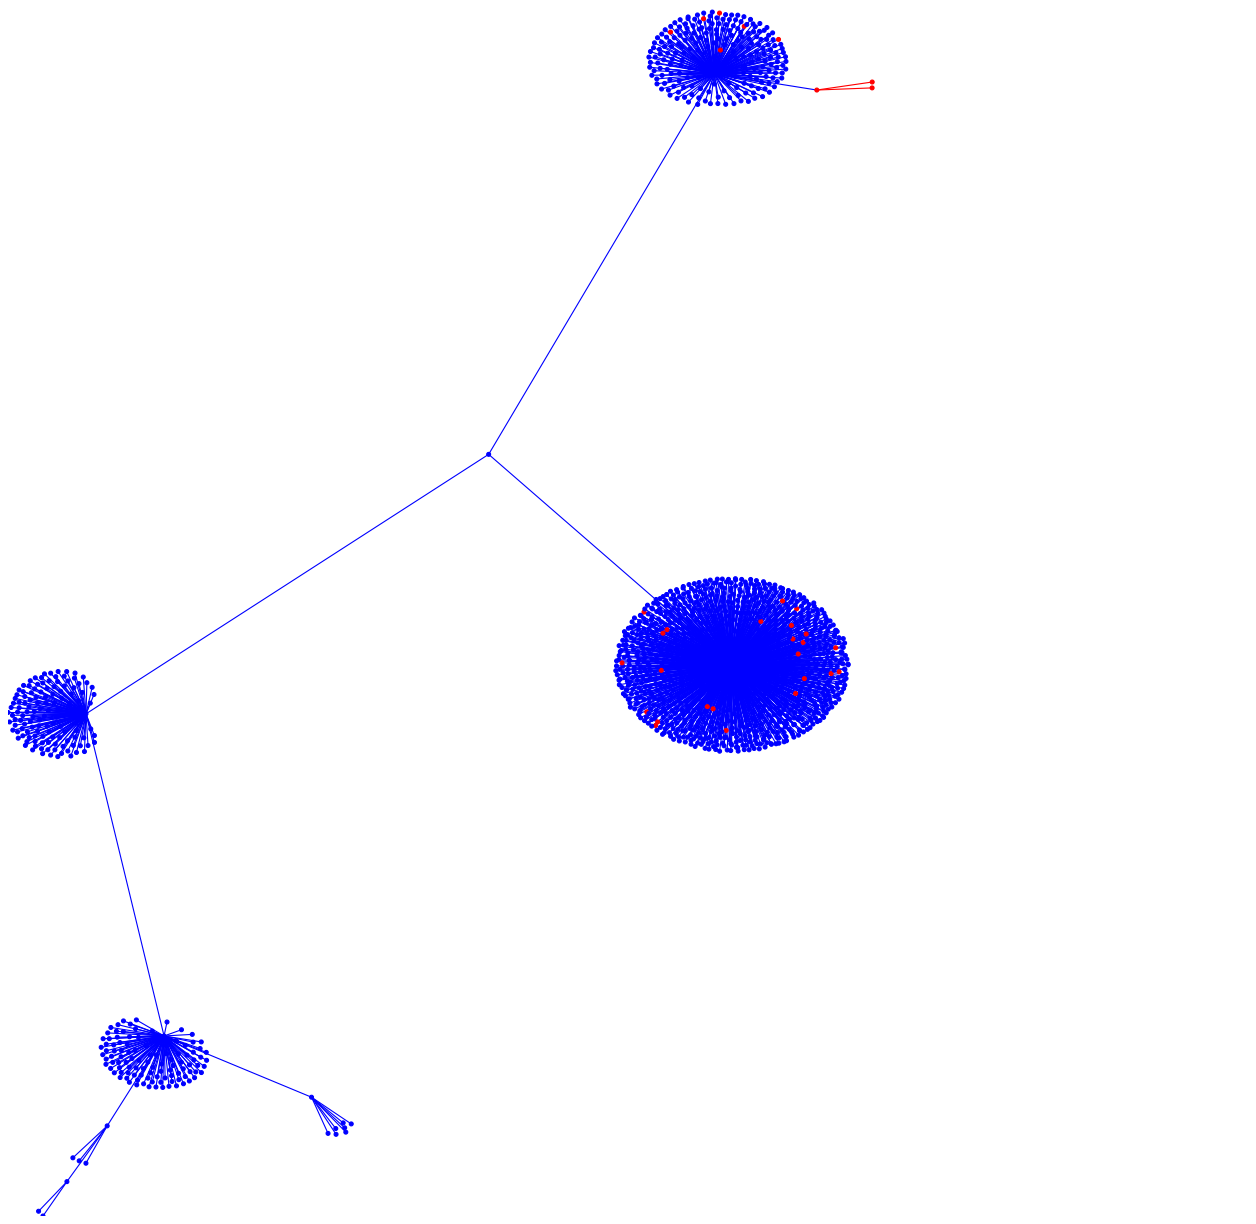

In [35]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G_mst, weight=None)
nx.draw_networkx_nodes(G_mst, pos, node_shape='.', node_size=50, node_color=node_colours)
nx.draw_networkx_edges(
    G_mst, pos,
    edge_color=[('blue' if lbls[(LBLTYPE, seqid_train)] == 0 else 'red')
                for seqid_train in nx.get_edge_attributes(G_mst, "seqid_train").values()]
)
# Text plotting
#for seqid in G_mst.nodes():
#    if G_mst.degree[seqid] > 1:
#        plt.text(pos[seqid][0], pos[seqid][1],
#                 seqs.loc[seqid]["seq"].compute().values[0])
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.savefig(GRAPHS + "reuters-mst.svg", format="svg", bbox_inches='tight')
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G_mst.nodes():
    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for _, _, seqid_train in G_mst.edges(seqid, data="seqid_train"):
        lbl = lbls[(LBLTYPE, seqid_train)]
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    if len(G_mst.edges(seqid)) > 1:
        print("Votes for central node", seqid, "with true label",
              lbls[(LBLTYPE, seqid)], "are", cur_lbls, ". Classified as", max_lbl, ".")
        print("Central node reads", seqs.loc[seqid]["seq"].compute().values[0])
    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G_mst.nodes()))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))

In [18]:
df2 = pd.read_csv(FOLDER + "traingraph.csv")
df2 = df2[(df2["compid"] == COMPNAME) & (df2["ncd_formula"] == NCD_FORMULA)]

In [19]:
# add training labels to `lbls`
# and also keep track of which are training nodes
train_nodes = set()
for seqid_train, _ in seqs[seqs["seqpart"] == 0].iterrows():
    train_nodes.add(seqid_train)

In [20]:
G2 = nx.from_pandas_edgelist(df2, "seqid_other", "seqid_train", ["ncd_value"])
G2_mst = nx.minimum_spanning_tree(G2, weight="ncd_value")

In [ ]:
node_colours2 = [
    ('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') if node not in train_nodes
    else 'black'
    for node in G2.nodes()
]
edge_colours2 = [
    ('blue' if lbls[(LBLTYPE, u)] == 0 else 'red') if u in train_nodes
    else ('blue' if lbls[(LBLTYPE, v)] == 0 else 'red')
    for (u, v) in G2_mst.edges()
]

plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G2_mst, weight=None)
nx.draw_networkx_nodes(G2_mst, pos, node_size=50, node_shape='.',
                       node_color=node_colours2)
nx.draw_networkx_edges(
    G2_mst, pos,
    edge_color=edge_colours2
)
#for seqid in G2_mst.nodes():
#    if G2_mst.degree[seqid] > 1 and seqs[seqs.index == seqid]["seqpart"].iloc[0] > 0:
#        plt.text(pos[seqid][0], pos[seqid][1],
#                 seqs.loc[seqid]["seq"].compute().values[0])
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G2_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for seqid_train in G2_mst.neighbors(seqid):
        lbl = lbls[(LBLTYPE, seqid_train)]
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G2_mst.nodes()))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))

In [ ]:
lbl_bool = df2["seqid_train"].apply(lambda seqid_train: lbls[(LBLTYPE, seqid_train)] == 0, meta=('seqid_train', 'bool'))

G3a = nx.from_pandas_edgelist(df2[lbl_bool], "seqid_other", "seqid_train", ["ncd_value"])
G3a_mst = nx.minimum_spanning_tree(G3a, weight="ncd_value")

G3b = nx.from_pandas_edgelist(df2[~lbl_bool], "seqid_other", "seqid_train", ["ncd_value"])
G3b_mst = nx.minimum_spanning_tree(G3b, weight="ncd_value")

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G3a_mst, weight=None)
nx.draw_networkx_nodes(G3a_mst, pos, node_size=50, node_shape='.',
                       node_color=[('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G3a_mst.nodes()])
nx.draw_networkx_edges(
    G3a_mst, pos
)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G3b_mst, weight=None)
nx.draw_networkx_nodes(G3b_mst, pos, node_size=50, node_shape='.',
                       node_color=[('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G3b_mst.nodes()])
nx.draw_networkx_edges(
    G3b_mst, pos
)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G3a_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    degree_a, degree_b = len(G3a_mst.edges(seqid)), len(G3b_mst.edges(seqid))
    if degree_b > 2:
        print(seqid)
        max_lbl = 1
    else:
        max_lbl = 0
    #if degree_a > degree_b:
    #    max_lbl = 0
    #else:
    #    max_lbl = 1

    #if abs(degree_a - degree_b) > 1:
    #    print("Decisive node seqid=", seqid, "had degrees", degree_a, degree_b, "with true label", lbls[(LBLTYPE, seqid)])
    #    print("Decisive node reads", seqs.loc[seqid]["seq"].compute().values[0])
    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / sum(conf_matrix[0] + conf_matrix[1]))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))